<a href="https://colab.research.google.com/github/ekqlsrla/ESAA-2/blob/main/HW/0926_Titanic_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold,learning_curve


In [ ]:
sns.set(style = 'white', context = 'notebook',palette= 'deep')

---
#2. Load and Check data

## 1) Load Data

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/DATA/train_titanic.csv')
test = pd.read_csv('/content/drive/MyDrive/DATA/test_titanic.csv')
IDtest = test['PassengerId']

## 2) Outlier detection

In [ ]:
def detect_outliers(df,n,features) :
  outlier_indices = []

  for col in features :
    Q1 = np.percentile(df[col],25)
    Q3 = np.percentile(df[col],75)
    IQR = Q3 - Q1

    outlier_step = 1.5 *IQR

    outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

    outlier_indices.extend(outlier_list_col)

  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list(k for k, v in outlier_indices.items()if v > n)

  return multiple_outliers

Outliers_to_drop = detect_outliers(train,2,['Age','SibSp','Parch','Fare'])


In [ ]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [ ]:
#Drop Outliers

train = train.drop(Outliers_to_drop,axis = 0).reset_index(drop = True)

## 3) Joining train and test set

In [ ]:
train_len = len(train)
dataset = pd.concat(objs = [train,test],axis = 0).reset_index(drop = True)

## 4) Check for null and missing values

In [ ]:
dataset = dataset.fillna(np.nan)

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [ ]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


---
#3. Feature analysis

## 1) Numerical values

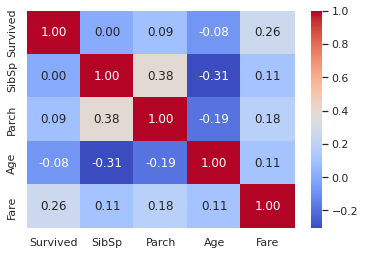

In [ ]:
g = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot = True, fmt = '.2f',cmap = 'coolwarm')

* SibSP

1. 혼자/1~2명이었던 고객이 더 많이 살아남음

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


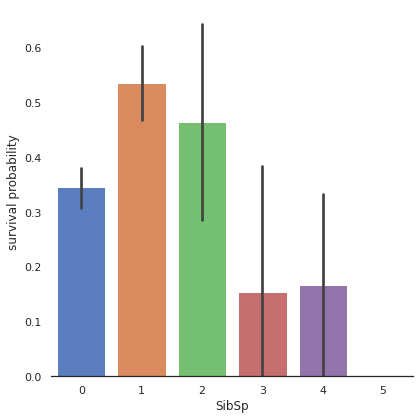

In [ ]:
g = sns.factorplot(x = 'SibSp',y = 'Survived',data = train,kind = 'bar',size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

* Parch

1. small families가 다른 그룹보다 더 많이 살아남음

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


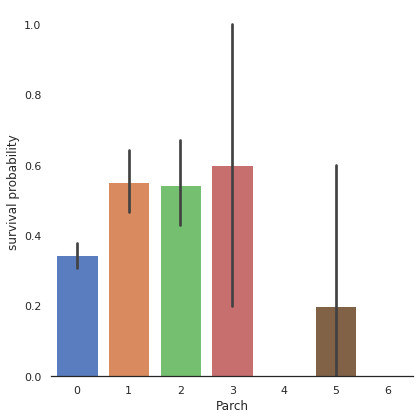

In [ ]:
g = sns.factorplot(x = 'Parch',y = 'Survived', data = train,kind = 'bar',size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

* Age

1. 60~80에서 생존률이 낮음
2. Age 변수는 Survived와 큰 관련이 없음

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


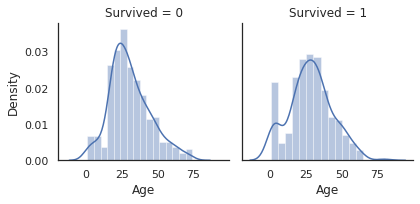

In [ ]:
g = sns.FacetGrid(train,col = 'Survived')
g = g.map(sns.distplot,'Age')

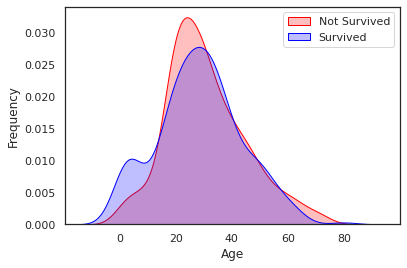

In [ ]:
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color = "Red",shade = True)

g= sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())],ax = g,color = 'Blue',shade = True)

g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived','Survived'])

* Fare

In [ ]:
dataset['Fare'].isnull().sum()

1

In [ ]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


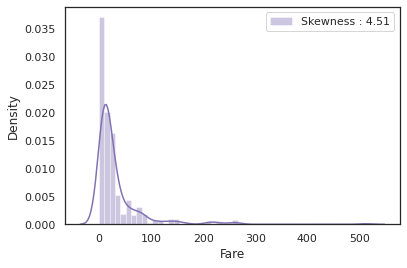

In [ ]:
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

In [ ]:
#Apply log to reduct skewness distribution

dataset['Fare'] = dataset['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


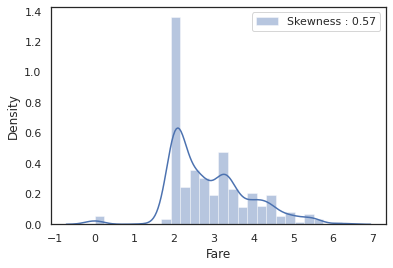

In [ ]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

## 2) Categorical Values

* Sex

1. 남성보다 여성이 더 많이 살아남음

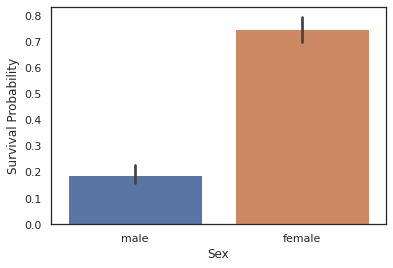

In [ ]:
g = sns.barplot(x = 'Sex',y = 'Survived', data = train)
g = g.set_ylabel('Survival Probability')

In [ ]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


* Pclass

1. 1등석이 제일 많이 살아남음

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


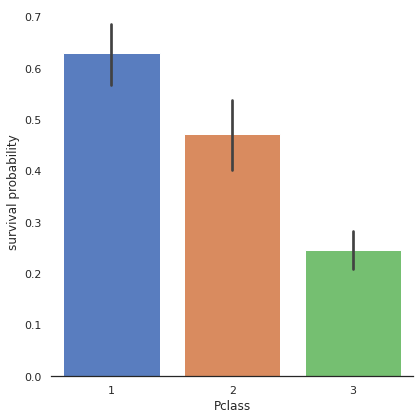

In [ ]:
g = sns.factorplot(x = 'Pclass',y = 'Survived',data = train,kind = 'bar',size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


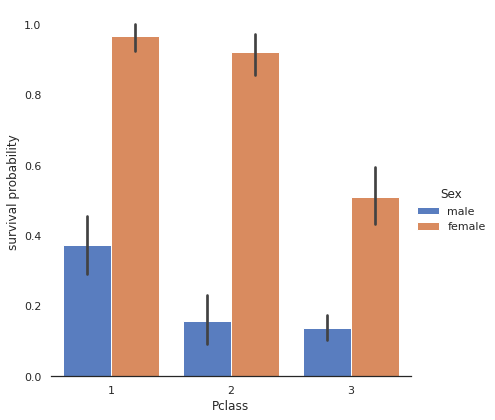

In [ ]:
g = sns.factorplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, size = 6, kind = 'bar', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

* Embarked

1. Cherbourg(C)의 승객이 더 많이 살아 남음

In [ ]:
dataset['Embarked'].isnull().sum()

2

In [ ]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


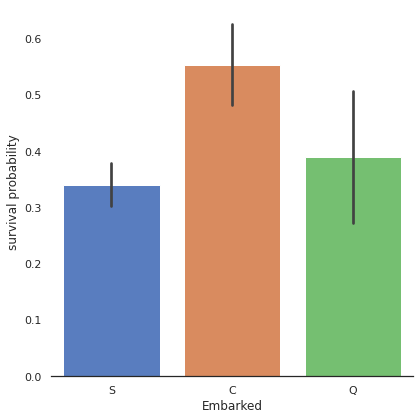

In [ ]:
g = sns.factorplot(x = 'Embarked', y = 'Survived',data = train,size = 6, kind = 'bar', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


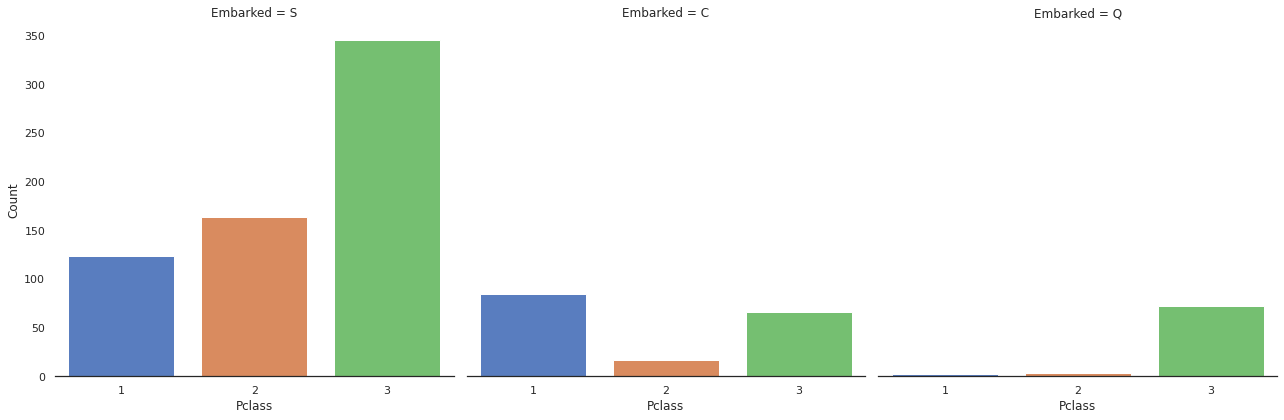

In [ ]:
g = sns.factorplot('Pclass',col = 'Embarked',data = train, size = 6, kind = 'count', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Count')

---
# 4. Filling missing Values

## 1) Age

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

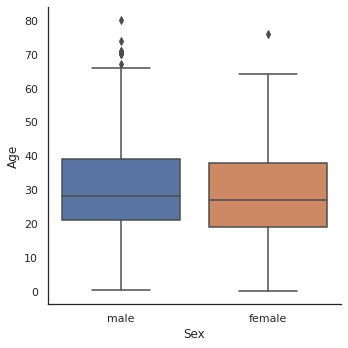

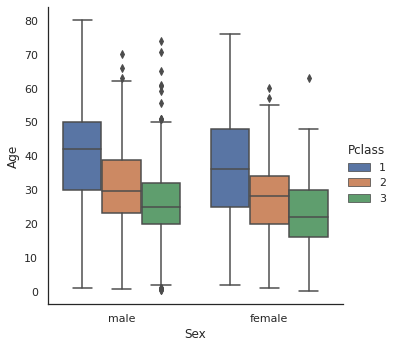

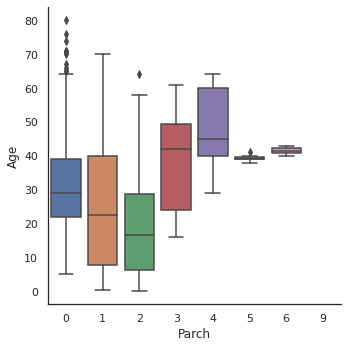

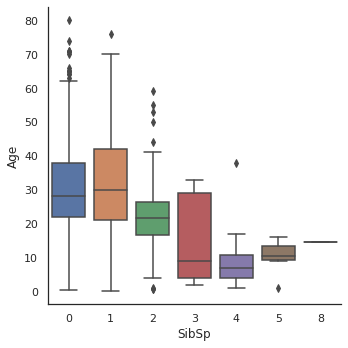

In [ ]:
g = sns.factorplot(y = 'Age', x = 'Sex',data = dataset,kind = 'box')
g = sns.factorplot(y = 'Age', x = 'Sex', hue = 'Pclass', data = dataset,kind = 'box')
g = sns.factorplot(y = 'Age',x = 'Parch',data = dataset,kind = 'box')
g = sns.factorplot(y = 'Age',x = 'SibSp', data = dataset,kind = 'box')

In [ ]:
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female': 1})

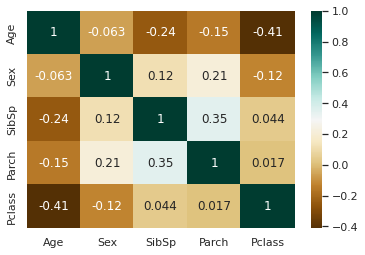

In [ ]:
g = sns.heatmap(dataset[['Age','Sex','SibSp','Parch','Pclass']].corr(),cmap = 'BrBG',annot = True)

In [ ]:
#Filling missing value of Age
##Fill Age with the median age of similar rows according to Pcalss, Parch and SibSp

index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age :
  age_med = dataset['Age'].median()
  age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & (dataset['Parch'] == dataset.iloc[i]['Parch']) & (dataset['Pclass']))].median()
  if not np.isnan(age_pred) :
    dataset['Age'].iloc[i] = age_pred
  else :
    dataset['Age'].iloc[i] = age_med

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


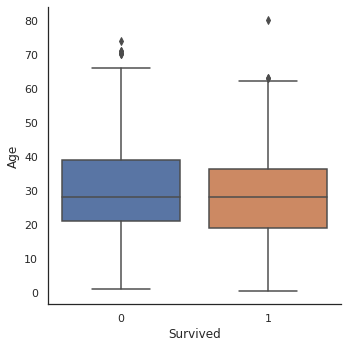

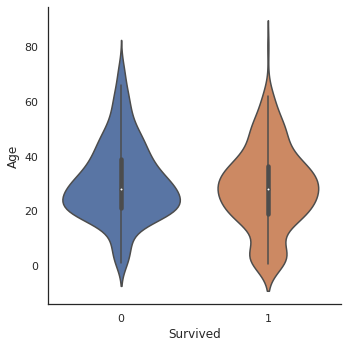

In [ ]:
g = sns.factorplot(x = 'Survived', y = 'Age', data = train,kind = 'box')
g = sns.factorplot(x = 'Survived', y = 'Age',data = train,kind = 'violin')

---
#5. Feature Engineering

## 1) Name/Title

In [ ]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [ ]:
dataset_title = [i.split(',')[1].split(".")[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)


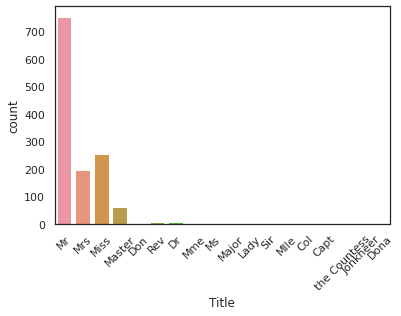

In [ ]:
g = sns.countplot(x = 'Title', data = dataset)
g = plt.setp(g.get_xticklabels(), rotation = 45)

In [ ]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


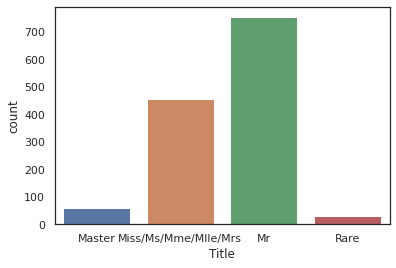

In [ ]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


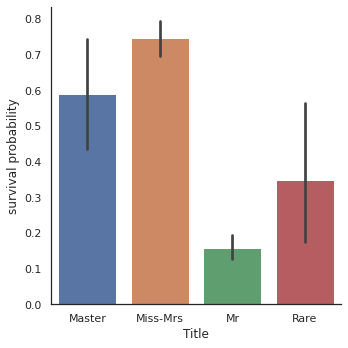

In [ ]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

In [ ]:
dataset.drop(labels = ['Name'],axis = 1, inplace = True)

## 2) Family Size

* Family Size가 생존률에 영향을 미치는 것을 확인할 수 있음

In [ ]:
#family size descriptor

dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


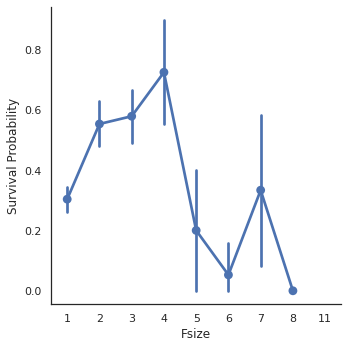

In [ ]:
g = sns.factorplot(x = 'Fsize' , y = 'Survived',data = dataset)
g = g.set_ylabels('Survival Probability')

In [ ]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

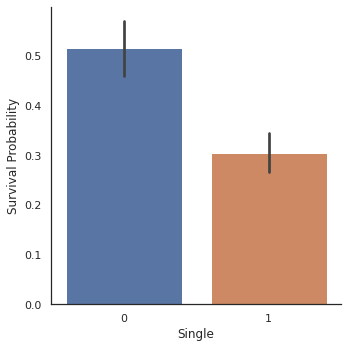

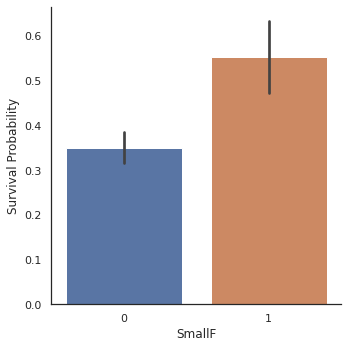

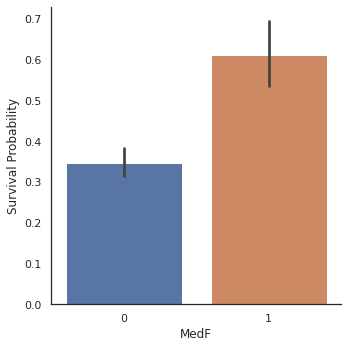

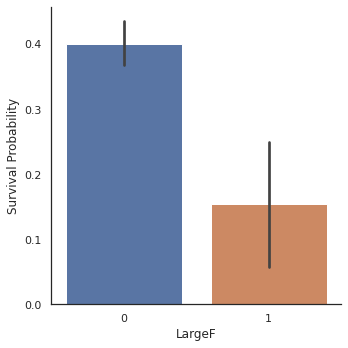

In [ ]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

In [ ]:
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset,columns = ['Embarked'],prefix = 'Em')

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


* Cabin

In [ ]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [ ]:
dataset['Cabin'].isnull().sum()

1007

In [ ]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [ ]:
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


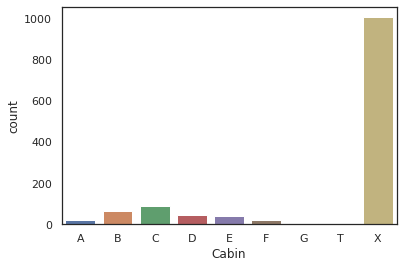

In [ ]:
g = sns.countplot(dataset['Cabin'],order = ['A','B','C','D','E','F','G','T','X'])

In [ ]:
dataset = pd.get_dummies(dataset,columns = ['Cabin'],prefix = 'Cabin')

* Ticket

In [ ]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [ ]:
Ticket = []
for i in list(dataset.Ticket) :
  if not i.isdigit() :
    Ticket.append(i.replace('.',"").replace('/','').strip().split(' ')[0])
  else :
    Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [ ]:
dataset = pd.get_dummies(dataset,columns = ['Ticket'], prefix = 'T')

In [ ]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'],prefix = 'Pc')

In [ ]:
dataset.drop(labels = ['PassengerId'], axis = 1, inplace = True)

In [ ]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


---
#6. MODELING

In [ ]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels = ['Survived'],axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train['Survived'] = train['Survived'].astype(int)

Y_train = train['Survived']

X_train = train.drop(labels = ['Survived'],axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## 1) Simple modeling

### (1) Cross validate model

1. SVC
2. DecisionTree
3. AdaBoost
4. RandomForest
5. Extra tress
6. Gradient Boosting
7. Multiple layer perception (neural network)
8. KNN
9. Logistic Regression
10. Linear Discriminant Analysis

In [ ]:
kfold = StratifiedKFold(n_splits = 10)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


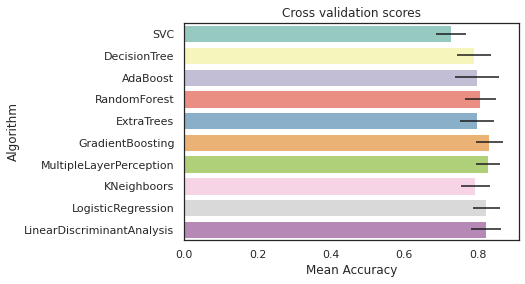

In [ ]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state = random_state), random_state = random_state, learning_rate = 0.1))
classifiers.append(RandomForestClassifier(random_state = random_state))
classifiers.append(ExtraTreesClassifier(random_state = random_state))
classifiers.append(GradientBoostingClassifier(random_state = random_state))
classifiers.append(MLPClassifier(random_state = random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
  cv_results.append(cross_val_score(classifier, X_train,y = Y_train,scoring = 'accuracy', cv = kfold, n_jobs = 4))

cv_means = []
cv_std = []
for cv_result in cv_results :
  cv_means.append(cv_result.mean())
  cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans' : cv_means, 'CrossValerrors' : cv_std, 'Algorithm' : ['SVC','DecisionTree','AdaBoost',
                                                                                             'RandomForest','ExtraTrees','GradientBoosting',
                                                                                             'MultipleLayerPerception','KNeighboors',
                                                                                             'LogisticRegression','LinearDiscriminantAnalysis']})

g = sns.barplot('CrossValMeans','Algorithm',data = cv_res, palette = 'Set3',orient = 'h', **{'xerr' : cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

In [ ]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC,random_state = 7)

ada_param_grid = {'base_estimator__criterion' : ['gini','entropy'],
                  'base_estimator__splitter' : ['best','random'],
                  'algorithm' : ['SAME','SAMME.R'],
                  'n_estimators' : [1,2],
                  'learning_rate' : [0.0001,0.001,0.01,0.1,0.2,0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv = kfold, scoring = 'accuracy',n_jobs = 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)
ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
560 fits failed out of a total of 1120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
560 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py", line 483, in fit
    raise ValueError("algorithm %s is not supported" % self.algorithm)
ValueError: algorithm SAME is not supported

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib/python3.7/dist-packa

In [ ]:
gsadaDTC.best_score_

0.8104570990806946

In [ ]:
#Extratrees

ExtC = ExtraTreesClassifier()

ex_param_grid = {
    'max_depth' : [None],
    'min_samples_split' : [2,3,10],
    'max_features' : [1,3,10],
    'min_samples_leaf' : [1,3,10],
    'bootstrap' :[False],
    'n_estimators' : [100,300],
    'criterion' : ['gini']
}

gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid,cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)
gsExtC.fit(X_train,Y_train)
ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8297497446373852

In [ ]:
#RFC

RFC = RandomForestClassifier()

rf_param_grid = {
    'max_depth' : [None],
    'max_features' : [1,3,10],
    'min_samples_split' : [2,3,10],
    'min_samples_leaf' : [1,3,10],
    'bootstrap' : [False],
    'n_estimators' : [100,300],
    'criterion' : ['gini']
}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid,cv=kfold,scoring = 'accuracy',n_jobs = 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.833158835546476

In [ ]:
#Gradient Boosting 

GBC = GradientBoostingClassifier()
gb_param_grid = {
    'loss' : ['deviance'],
    'n_estimators' : [100,200,300],
    'learning_rate' : [0.1,0.05,0.01],
    'max_depth' : [4,8],
    'min_samples_leaf' : [100,150],
    'max_features' : [0.3,0.1]
}

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid,cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsGBC.fit(X_train,Y_train)
GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8320097037793668

In [ ]:
#SVC Classifier

SVMC = SVC(probability = True)
svc_param_grid = {'kernel' : ['rbf'],
                  'gamma' : [0.001,0.01,0.1,1],
                  'C' : [1,10,50,100,200,300,1000]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4,verbose = 1)
gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_


gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.833158835546476

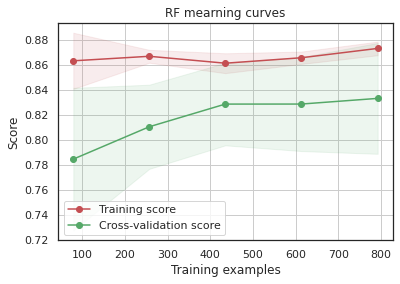

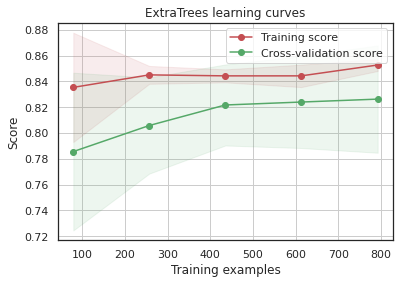

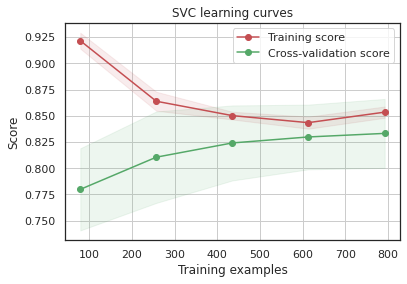

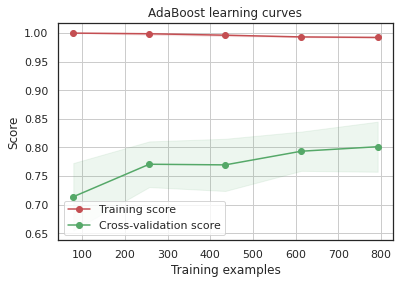

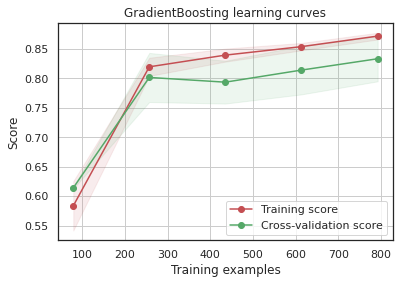

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

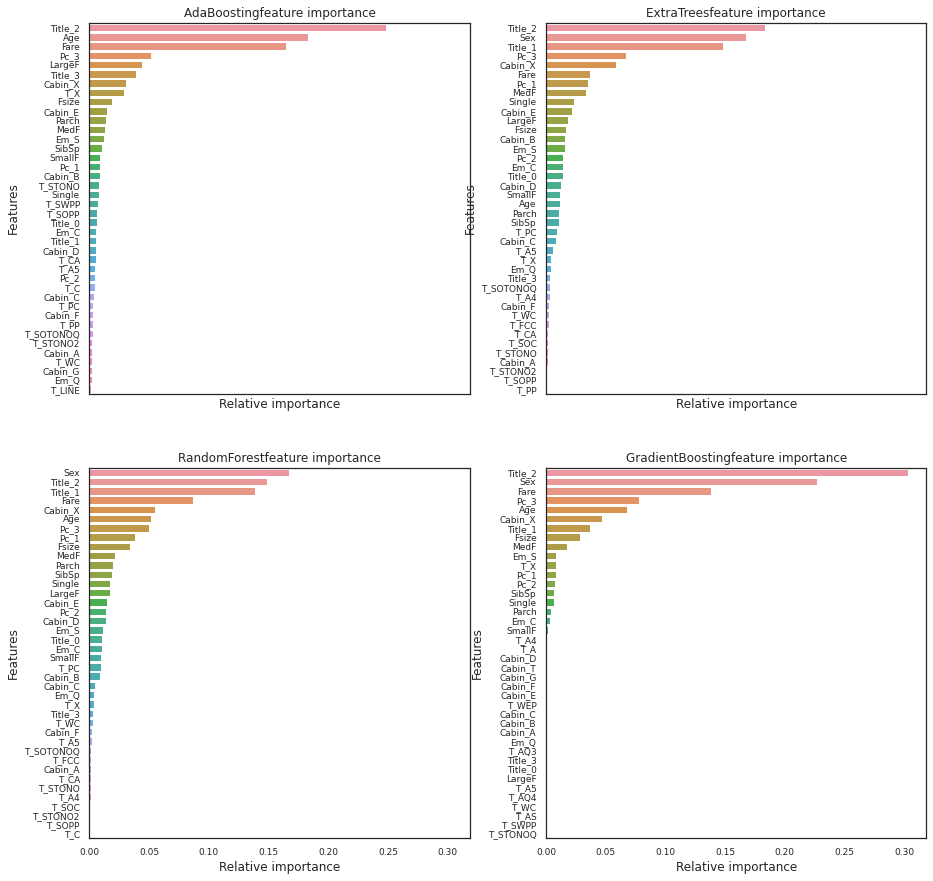

In [ ]:
nrows = ncols = 2
fig,axes = plt.subplots(nrows = nrows, ncols = ncols, sharex = 'all', figsize = (15,15))

names_classifiers = [('AdaBoosting',ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),('GradientBoosting',GBC_best)]

nclassifier = 0
for row in range(nrows) :
  for col in range(ncols) :
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    g = sns.barplot(y =X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40], orient = 'h',ax = axes[row][col])
    g.set_xlabel('Relative importance',fontsize = 12)
    g.set_ylabel('Features',fontsize = 12)
    g.tick_params(labelsize = 9)
    g.set_title(name + 'feature importance')
    nclassifier += 1

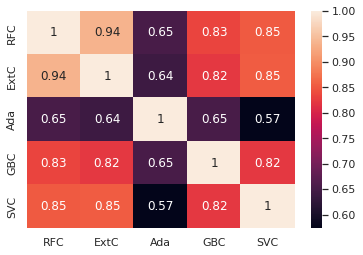

In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

## 2) Ensemble modeling

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

## 3) Prediction

In [ ]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("/content/drive/MyDrive/DATA/ensemble_python_voting.csv",index=False)